# MNIST handwritten digits

MLP - MNIST 손글씨 숫자 인식

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

## 1. Load Dataset

MNIST dataset loading

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()    # load mnist data
x_train, x_test = x_train, x_test

## 2. Dataset split

train dataset에 60000개 데이터가 있으므로, 랜덤하게 split하여 3만개의 학습데이터만 사용

In [3]:
rand_selected = random.sample([randn for randn in range(0, len(x_train))], 30000)
x_train = x_train[rand_selected]
y_train = y_train[rand_selected]

print(f"shape of x_train is {np.shape(x_train)}")
print(f"shape of y_train is {np.shape(y_train)}")
print(f"shape of x_test is {np.shape(x_test)}")
print(f"shape of y_test is {np.shape(y_test)}")

shape of x_train is (30000, 28, 28)
shape of y_train is (30000,)
shape of x_test is (10000, 28, 28)
shape of y_test is (10000,)


## 3. Training data preprocessing

### 3.1. Data enhance - By shifting

In [4]:
from scipy.ndimage.interpolation import shift

x_enhanced = []
y_enhanced = []

shifting_list = []

for ax in range(-2, 3):
    for ay in range(-2, 3):
        if (ax == 0 and ay == 0):
            continue
        shifting_list.append([ay, ax])

shifting_list = np.array(shifting_list)

for image, label in zip(x_train, y_train):
    rand_shifting_list = shifting_list[random.sample([randn for randn in range(0, len(shifting_list))], 8)]

    for y_shift, x_shift in rand_shifting_list:
        shifted_image = shift(image, [y_shift, x_shift])
        shifted_image.reshape([-1])
        x_enhanced.append(shifted_image)
        y_enhanced.append(label)

shifted_x_train = np.array(x_enhanced)
shifted_y_train = np.array(y_enhanced)

print(f"shape of shifted_x_train is {np.shape(shifted_x_train)}")
print(f"shape of shifted_y_train is {np.shape(shifted_y_train)}")

shape of shifted_x_train is (240000, 28, 28)
shape of shifted_y_train is (240000,)


### 3.2. Data enhance - By rotating

In [5]:
import imutils

x_enhanced = []
y_enhanced = []

rotating_list = [10, 20, 30]

for rotate_angle in rotating_list:
    for image, label in zip(x_train, y_train):
        positive_rotated_image = imutils.rotate(image, rotate_angle)
        negative_rotated_image = imutils.rotate(image, -rotate_angle)
        x_enhanced.append(positive_rotated_image)
        y_enhanced.append(label)
        x_enhanced.append(negative_rotated_image)
        y_enhanced.append(label)

rotated_x_train = np.array(x_enhanced)
rotated_y_train = np.array(y_enhanced)

print(f"shape of rotated_x_train is {np.shape(rotated_x_train)}")
print(f"shape of rotated_y_train is {np.shape(rotated_y_train)}")

shape of rotated_x_train is (180000, 28, 28)
shape of rotated_y_train is (180000,)


### 3.3 Enhanced data join

In [6]:
x_train = np.append(x_train, shifted_x_train, 0)
x_train = np.append(x_train, rotated_x_train, 0)
shifted_x_train = []
rotated_x_train = []

y_train = np.append(y_train, shifted_y_train, 0)
y_train = np.append(y_train, rotated_y_train, 0)
shifted_y_train = []
rotated_y_train = []

rand_selected = random.sample([x for x in range(0, len(x_train))], len(x_train))
x_train = x_train[rand_selected]
y_train = y_train[rand_selected]

print(f"shape of x_train is {np.shape(x_train)}")
print(f"shape of y_train is {np.shape(y_train)}")

shape of x_train is (450000, 28, 28)
shape of y_train is (450000,)


### 3.4. Data Normalize

In [7]:
mean = np.mean(x_train)
std = np.std(x_train)

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

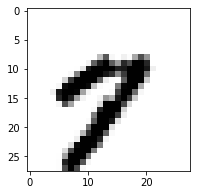

7


In [8]:
rand_num = random.randint(0, len(x_train))
plt.figure(figsize=(3, 3))
plt.imshow(x_train[rand_num], cmap='Greys')
plt.show()

print(y_train[rand_num])

## 4. MLP model define & learning

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4086, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(0.0005),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 4086)              3207510   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4086)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8370176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2

In [10]:
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=300)
checkpoint = keras.callbacks.ModelCheckpoint('./model1/', monitor='val_loss', save_best_only=True)

with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train, verbose=2, epochs=800, batch_size=64, validation_data=(x_test, y_test), callbacks=[earlyStop, checkpoint])

Epoch 1/800
7032/7032 - 97s - loss: 0.9735 - sparse_categorical_accuracy: 0.6817 - val_loss: 0.1227 - val_sparse_categorical_accuracy: 0.9721
INFO:tensorflow:Assets written to: ./model1\assets
Epoch 2/800
7032/7032 - 98s - loss: 0.3647 - sparse_categorical_accuracy: 0.9158 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9770
INFO:tensorflow:Assets written to: ./model1\assets
Epoch 3/800
7032/7032 - 96s - loss: 0.2977 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.0736 - val_sparse_categorical_accuracy: 0.9815
INFO:tensorflow:Assets written to: ./model1\assets
Epoch 4/800
7032/7032 - 96s - loss: 0.2638 - sparse_categorical_accuracy: 0.9418 - val_loss: 0.0699 - val_sparse_categorical_accuracy: 0.9818
INFO:tensorflow:Assets written to: ./model1\assets
Epoch 5/800
7032/7032 - 95s - loss: 0.2425 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.0716 - val_sparse_categorical_accuracy: 0.9849
Epoch 6/800
7032/7032 - 98s - loss: 0.2282 - sparse_categorical_accuracy: 0.9517 - val

KeyboardInterrupt: 

In [ ]:
best_model = keras.models.load_model('./model1/')

best_model.evaluate(x_test,  y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0957 - sparse_categorical_accuracy: 0.9782


[0.09570606052875519, 0.9782000184059143]